In [1]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"ardianzyh","key":"7b77075c876942baf04f6b03634f1b5f"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d shuvokumarbasak4004/jackfruit-leaf-diseases/train

 99% 284M/286M [00:12<00:00, 35.3MB/s]
100% 286M/286M [00:12<00:00, 24.6MB/s]


In [2]:
import os
import zipfile

path_to_zip_file = "/content/jackfruit-leaf-diseases.zip"
directory_to_extract_to = "/content/Jackfruit"  # Ganti dengan path folder tujuan ekstraksi

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    # Mendapatkan semua nama file dan direktori yang ada di dalam zip
    all_files = zip_ref.namelist()

    # Mendapatkan hanya nama file dan direktori yang berada di dalam folder "train"
    train_files = [file for file in all_files if file.startswith("Jackfruit/train/")]

    # Mengekstrak hanya file dan direktori yang berada di dalam folder "train"
    for file in train_files:
        zip_ref.extract(file, directory_to_extract_to)


In [3]:
import os
base_dir = '/content/Jackfruit/Jackfruit/train/'

In [4]:
print(os.listdir(base_dir))

['Algal_Leaf_Spot_of_Jackfruit', 'Black_Spot_of_Jackfruit', 'Healthy_Leaf_of_Jackfruit']


In [5]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 13211


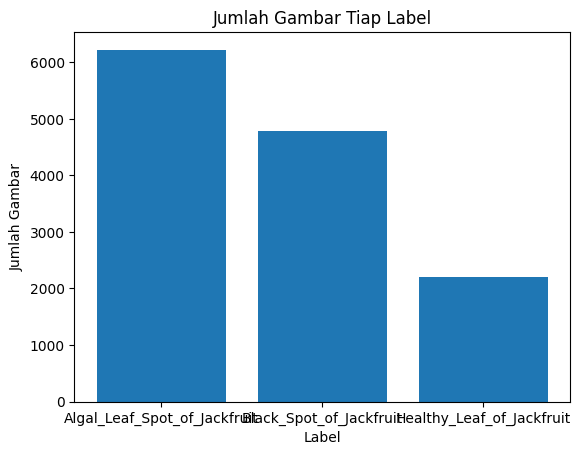

In [6]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

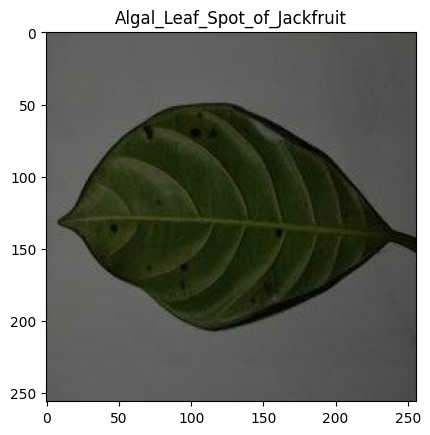

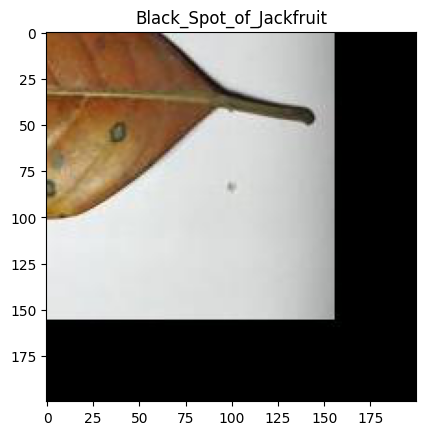

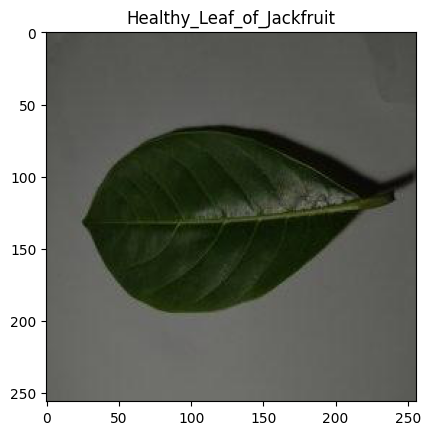

In [7]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

In [8]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [9]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [10]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 10570 images belonging to 3 classes.
Found 2641 images belonging to 3 classes.


In [11]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

In [12]:
# Membuat arsitektur model CNN

cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

In [13]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
331/331 [==============================] - 50s 99ms/step - loss: 0.3188 - accuracy: 0.8693 - val_loss: 0.3441 - val_accuracy: 0.8622
Epoch 2/20
331/331 [==============================] - 32s 96ms/step - loss: 0.1429 - accuracy: 0.9490 - val_loss: 0.2045 - val_accuracy: 0.8947
Epoch 3/20
331/331 [==============================] - 31s 93ms/step - loss: 0.0839 - accuracy: 0.9698 - val_loss: 0.6621 - val_accuracy: 0.8610
Epoch 4/20
331/331 [==============================] - 33s 100ms/step - loss: 0.0693 - accuracy: 0.9758 - val_loss: 0.2649 - val_accuracy: 0.9209
Epoch 5/20
331/331 [==============================] - 31s 94ms/step - loss: 0.0541 - accuracy: 0.9822 - val_loss: 0.4339 - val_accuracy: 0.9057
Epoch 6/20
331/331 [==============================] - 32s 96ms/step - loss: 0.0786 - accuracy: 0.9759 - val_loss: 0.4548 - val_accuracy: 0.8959
Epoch 7/20
331/331 [==============================] - 31s 95ms/step - loss: 0.0324 - accuracy: 0.9897 - val_loss: 1.3693 - val_accuracy

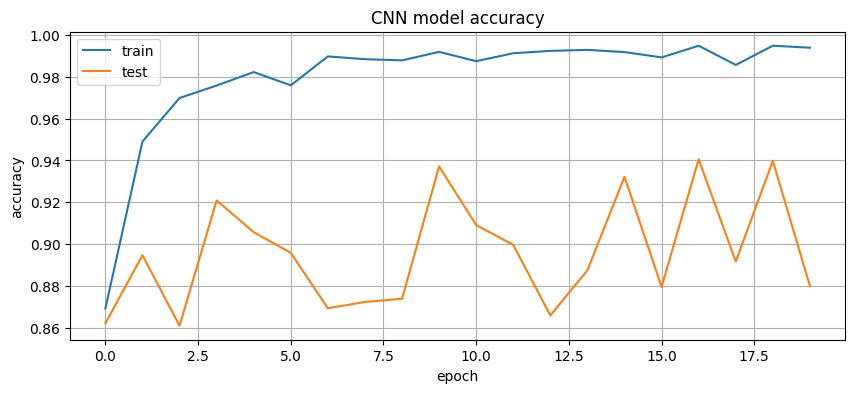

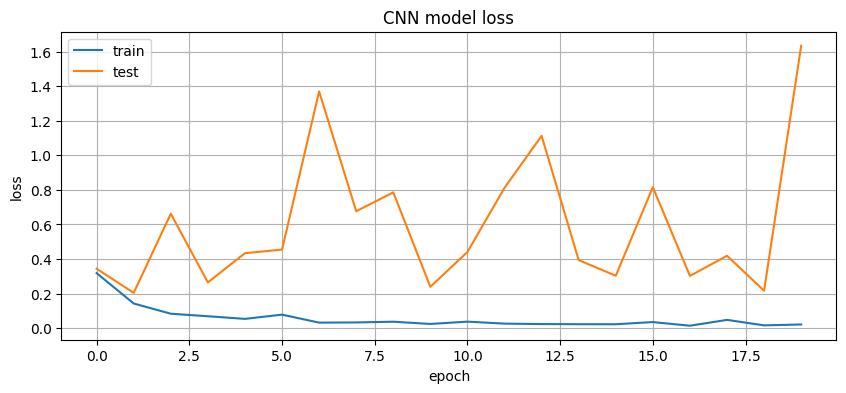

In [14]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
331/331 [==============================] - 73s 202ms/step - loss: 0.4813 - accuracy: 0.7891 - val_loss: 0.2792 - val_accuracy: 0.8963
Epoch 2/20
331/331 [==============================] - 55s 165ms/step - loss: 0.2891 - accuracy: 0.8886 - val_loss: 0.2117 - val_accuracy: 0.9254
Epoch 3/20
331/331 [==============================] - 53s 159ms/step - loss: 0.2463 - accuracy: 0.9052 - val_loss: 0.1456 - val_accuracy: 0.9542
Epoch 4/20
331/331 [==============================] - 53s 160ms/step - loss: 0.2267 - accuracy: 0.9115 - val_loss: 0.1591 - val_accuracy: 0.9451
Epoch 5/20
331/331 [==============================] - 53s 161ms/step - loss: 0.2171 - accuracy: 0.9153 - val_loss: 0.1841 - val_accuracy: 0.9318
Epoch 6/20
331/331 [==============================] - 53s 161ms/step - loss: 0.1856 - accuracy: 0.9270 - val_loss: 0.1165 - val_accuracy: 0.9693
Epoch 7/20
331/331 [==============================] - 53s 160ms/step - loss: 0.1809 - accuracy: 0.9303 - val_loss: 0.1034 - val_ac

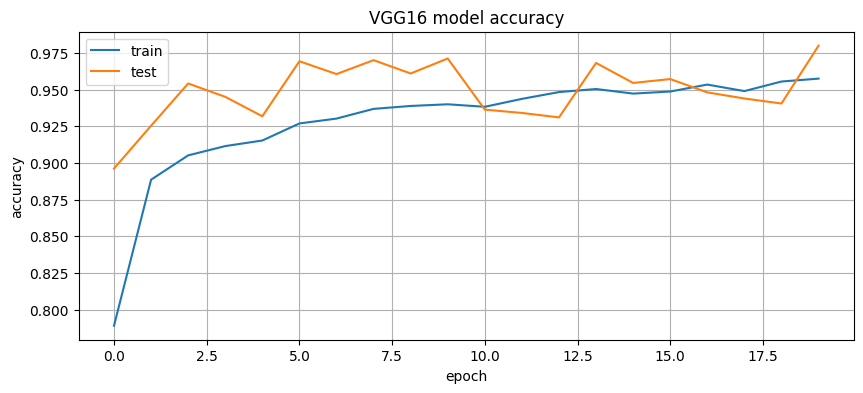

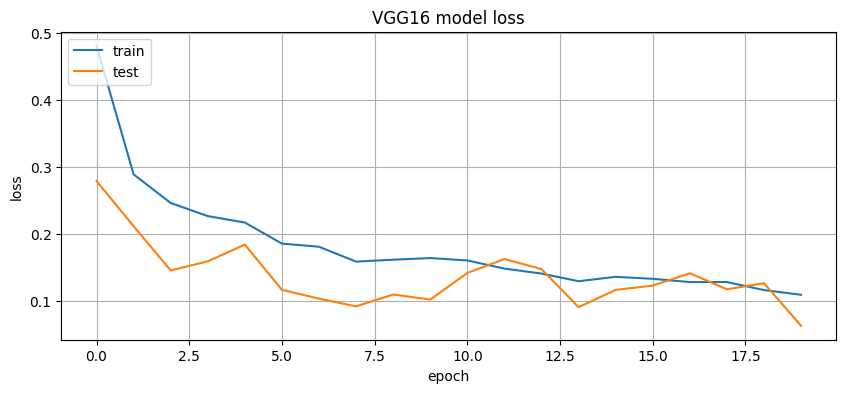

In [17]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [20]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception

## Loading Xception model
base_xception_model = Xception(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_xception_model.trainable = False

# Preprocessing Input
xception_preprocess = tf.keras.applications.xception.preprocess_input
train_data.preprocessing_function = xception_preprocess
# Transfer learning dengan Xception
xception_model = tf.keras.models.Sequential([
  data_augmentation,
  base_xception_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compiling model
xception_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)


83683744/83683744 [==============================] - 3s 0us/step


In [21]:
# Melatih model xception
xception_hist = xception_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
331/331 [==============================] - 54s 151ms/step - loss: 0.3032 - accuracy: 0.9084 - val_loss: 0.0678 - val_accuracy: 0.9746
Epoch 2/20
331/331 [==============================] - 47s 142ms/step - loss: 0.1190 - accuracy: 0.9585 - val_loss: 0.0743 - val_accuracy: 0.9701
Epoch 3/20
331/331 [==============================] - 48s 143ms/step - loss: 0.0898 - accuracy: 0.9673 - val_loss: 0.0797 - val_accuracy: 0.9682
Epoch 4/20
331/331 [==============================] - 47s 143ms/step - loss: 0.0879 - accuracy: 0.9679 - val_loss: 0.1142 - val_accuracy: 0.9606
Epoch 5/20
331/331 [==============================] - 47s 141ms/step - loss: 0.0887 - accuracy: 0.9696 - val_loss: 0.0832 - val_accuracy: 0.9799
Epoch 6/20
331/331 [==============================] - 47s 141ms/step - loss: 0.0837 - accuracy: 0.9686 - val_loss: 0.3705 - val_accuracy: 0.8906
Epoch 7/20
331/331 [==============================] - 47s 142ms/step - loss: 0.0820 - accuracy: 0.9719 - val_loss: 0.0593 - val_ac

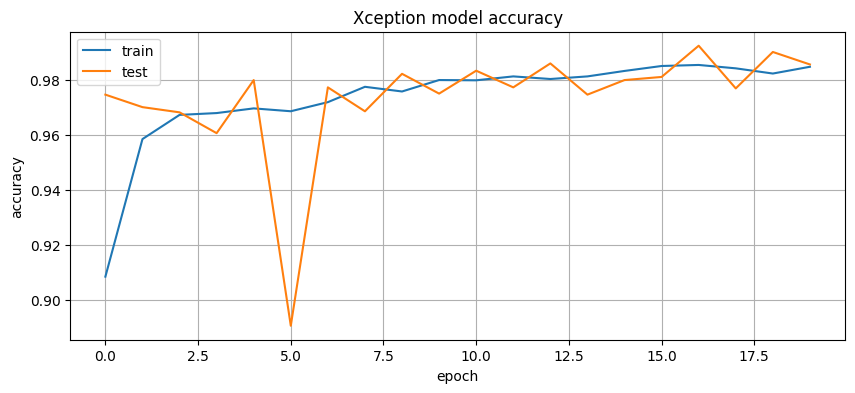

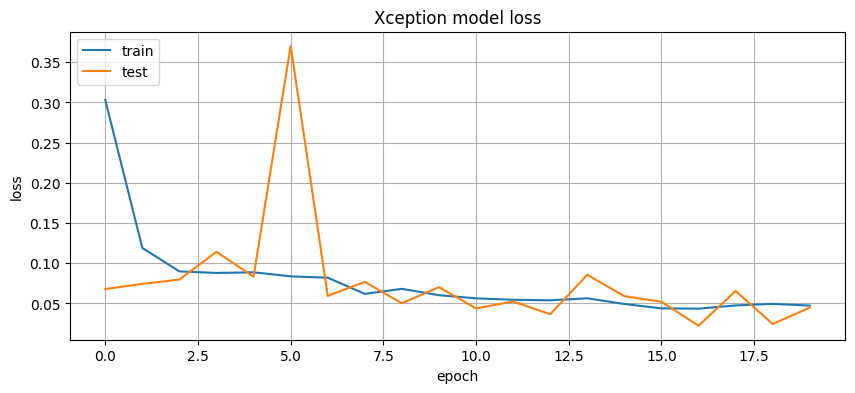

In [27]:
# Membuat plot akurasi model Xception
plt.figure(figsize=(10,4))
plt.plot(xception_hist.history['accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.title('Xception model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model Xception
plt.figure(figsize=(10,4))
plt.plot(xception_hist.history['loss'])
plt.plot(xception_hist.history['val_loss'])
plt.title('Xception model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

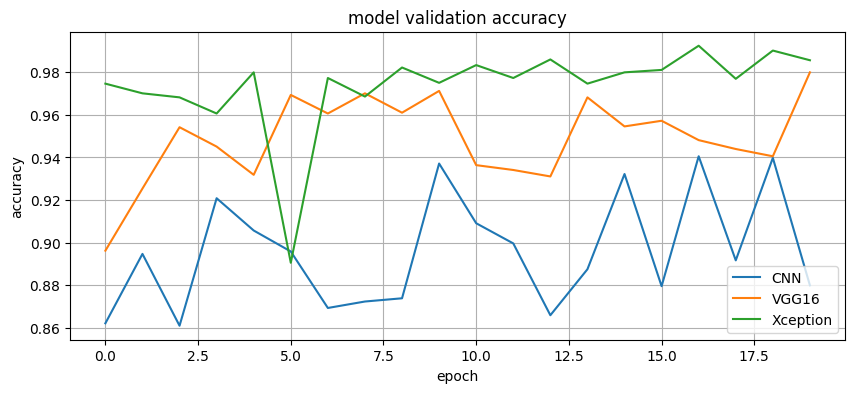

In [28]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(xception_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'Xception'], loc='lower right')
plt.grid(True)
plt.show()

In [29]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'Algal_Leaf_Spot_of_Jackfruit': 0,
 'Black_Spot_of_Jackfruit': 1,
 'Healthy_Leaf_of_Jackfruit': 2}

Saving IMG_20230308_142749_1.jpg to IMG_20230308_142749_1.jpg
1/1 [==============================] - 0s 39ms/step
IMG_20230308_142749_1.jpg
Algal_Leaf_Spot


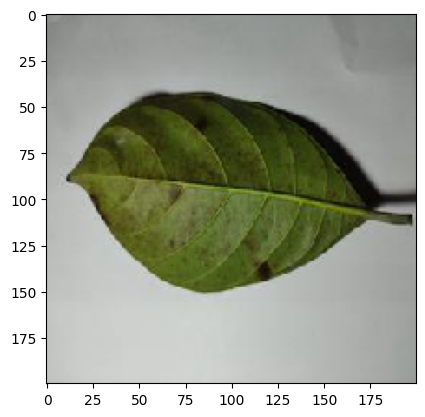

In [31]:
# Menguji coba model
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from google.colab import files
%matplotlib inline


#file upload, kode di bawah in hanya bisa dijalankan di google colab dengan mengimport from google.colab import files. Silahkan kalian ganti kodingannya agar bisa upload di jupyter notebook masing-masing
#atau kalian langsung import file gambarnya langsung
uploaded = files.upload()

for fn in uploaded.keys():

  # prediksi gambar
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = xception_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)

  print(fn)
  if classes==0:
    print('Algal_Leaf_Spot')
  elif classes==1:
    print('Black_Spot')
  else:
    print('Healthy_Leaf')